# Import Statements

In [2]:
import numpy as np
import pandas as pd
import math
import cmath
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import scipy
from scipy import signal

import watermark 

# GPU code

In [3]:
# This will throw an error if you don't have a GPU

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Generation

In [4]:
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is

In [5]:
# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(3) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element
RX[2] = RX[1] - lambda1/2  # Location of bottom RX element

In [6]:
# Antenna Geometry
horz_elements = 3 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# I don't think having 2d arrays matter for this problem
# using the 1d case for now for simplicity the 2d code works
elements = [ [] for _ in range(horz_elements)]
# elements = [[ [] for _ in range(horz_elements)] for _ in range(vert_elements)] # create a empty 2D matrix
angleofArrival = [] # empty matrix to store angle
print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 this really confused me

[[], [], []]


In [7]:
# shrinking the size of the signal so it is easier to work with
# Will want to take random samples from this at some point
N = 256 # size of the sample, fft size
aveN = 10

small_samples = np.zeros(N, complex) # blank array to store the data

Tsamples = np.zeros((aveN,N),dtype=complex)
for k in range(aveN):
    for i in range(N):
        Tsamples[k,i] = samples[i+N*k]

# # Create smaller signal to work with
# for i in range(N):
#     small_samples[i] = samples[i]

# checking the size of the sample
print(small_samples.shape)

(256,)


In [8]:
# Generating the Data for the NN
numberofSamples = 1000

for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(3)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element
    angle[2] = np.arctan((TX-RX[2])/L)  # Angle seen at bottom RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(3) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(3) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2
    td[2] = D[2]/c0 # time delay for element 3

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
    # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    shift2 = np.zeros((aveN,N),dtype=complex)
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])
        shift2[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[2])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])
        shift2[i,:] = np.fft.ifftshift(shift2[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
        shift2[i,:] = np.fft.ifft(shift2[i,:])
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift1) # storing the data for element 2 
    elements[2].append(shift2) # storing the data for element 3
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[0.00000000e+00 1.01291511e-11 2.03826970e-11]
[2.8274368  2.86240523 2.89737152]


In [9]:
# checking the shape and values for element 1
element1 = np.array(elements[0])
print(element1.shape)

# checking the shape and values for elements
test = np.array(elements)
print(test.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(1000, 10, 256)
(3, 1000, 10, 256)


In [10]:
# converting to numpy array to improve preformance and to improve
# the useability of the list (more features)
ANGLE = np.array(angleofArrival)
maxAngle = max(ANGLE)
minAngle = min(ANGLE)

# checking the shape and values ffor angleofArrival
print(ANGLE.shape)

# for i in ANGLE:
#     print(i)

(1000,)


# Data Processing

In [11]:
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])
element3 = np.array(elements[2])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(1000, 10, 256)
(10, 256)


In [12]:
# This is still isn't working the output shape of (3,128,100) isn't what I want. I want something like (100,3,128)

# Cross correlating elements
# I am trying to make get this to correlate all relvent combinations of elemenents just based off of antenna geo
# Right now I have the behavior I want, but not the indexing of elements
# y will iterate num_elements-1, which is 0-num_elements-1, the last row doesn't matter
# x will iterate num_elements-1, which 1-num_elements-1, the first col doesn't matter
# this will also decrease by one each time through the loop so that it "steps" over by one
# think of it as walking down mc esher stairs form left ot right.

# corr each time step then take the mean 
count = 0
corr = [[] for _ in range(horz_elements)] # creating a blank array to store the correlations in

# Loops y and x step through possible element cross correlations
for y in range(num_elements-1):
    for x in range(num_elements-y-1):
        
        # taking the (elements#, numberofSamples, aveN, Samples) to (numberofSamples, aveN, Samples)
        eleTemp1 = np.array(elements[y])     # stores the first element being cross-correlated
        eleTemp2 = np.array(elements[x+y+1]) # stores the second element being cross-correlated
        
        # zero matrix for storing the average for each sample
        avg = []
        
        # Loops through the number of samples
        for n in range(numberofSamples):
            # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
            temp1 = np.array(eleTemp1[n])
            temp2 = np.array(eleTemp1[n])
            
            # zero matrix to store the correlations between samples
            S_all = np.zeros(N,dtype=complex)
            
            # Loops through the aveN 
            for i in range(aveN):
                # takes the correlation between element#(n, i, samples)
                temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
                S_all += temp  
                #averag the magnitudes      
            
            
            avg.append(S_all/aveN)
        corr[count] = avg
        count += 1
        
test = np.array(corr)
print(test.shape)

(3, 1000, 256)


C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-13-b12dfd3739df>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


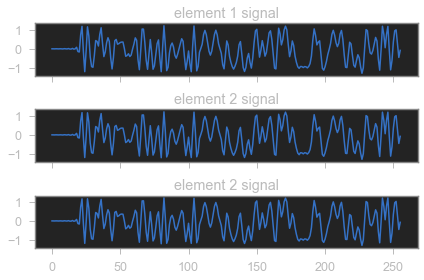

In [13]:
# making indexing specific rows of data easier
element1 = np.array(elements[0])
element2 = np.array(elements[1])
element3 = np.array(elements[2])

# Plotting the data to make sure it looks correct before moving on
fig, (ax_ele1, ax_ele2, ax_ele3) = plt.subplots(3, 1, sharex=True)

# picking a random index to sample from
sample = randint(0,numberofSamples-1)

# Element 1, no phase shift
ax_ele1.plot(element1[sample][0])
ax_ele1.set_title('element 1 signal')

# Element 2, phase shifted verion of element 1
ax_ele2.plot(element2[sample][0])
ax_ele2.set_title('element 2 signal')

# Element 2, phase shifted verion of element 1
ax_ele3.plot(element3[sample][0])
ax_ele3.set_title('element 2 signal')

fig.tight_layout()
fig.show()

C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-14-f60eb3b837a9>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


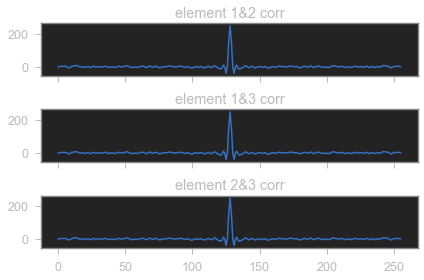

In [14]:
# making indexing specific rows of data easier
corr1 = np.array(corr[0]) # 1&2
corr2 = np.array(corr[1]) # 1&3
corr3 = np.array(corr[2]) # 2&3

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_corr1, ax_corr2, ax_corr3) = plt.subplots(3, 1, sharex=True)

# picking a random index to sample from
sample = randint(0,numberofSamples-1)

# Element 1, no phase shift
ax_corr1.plot(corr1[sample])
ax_corr1.set_title('element 1&2 corr')

# Element 2, phase shifted verion of element 1
ax_corr2.plot(corr2[sample])
ax_corr2.set_title('element 1&3 corr')

# Element 2, phase shifted verion of element 1
ax_corr3.plot(corr3[sample])
ax_corr3.set_title('element 2&3 corr')

fig.tight_layout()
fig.show()

# Data for NN

In [15]:
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr,np.zeros((num_elements,numberofSamples,N))),axis=-1)
print(polarCorr.shape)

for n in range(num_elements):
    for j in range(numberofSamples):
        for i in range(N):
            temp = abs(tempCorr[n][j][i])
            temp2 = cmath.phase(tempCorr[n][j][i])
            polarCorr[n][j][i] = int(temp)
            polarCorr[n][j][N+i] = int(temp)
            
            
print(type(temp))
# Getting the real and imginary value for the NN
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=2)
# print(corr.shape)

(3, 1000, 256)
(3, 1000, 512)
<class 'numpy.float64'>


In [16]:
angleofArrival = np.array(angleofArrival)

train_labels = angleofArrival
train_samples = complexCorr

In [17]:
print(train_samples.shape)

# for i in train_samples:
#     print(i)

(3, 1000, 512)


In [18]:
print(train_labels.shape)

# for i in train_labels:
#     print(i)

(1000,)


In [19]:
# scaling the NN between 0 and 1
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1 was 0,1

scaled_train_samples = train_samples
for i in range(2):
    scaled_train_samples[i] = scaler.fit_transform(train_samples[i])
    
scaled_train_samples = scaled_train_samples.reshape(numberofSamples,3,N*2) # reshaping to match the label relationship
scaled_train_labels = scaler.fit_transform(train_labels.reshape(-1,1)) #  this is reshaping from (100,) to (100,1)

# scaled_train_labels = scaled_train_labels[0:100] was trying to see if have (100,3) was causing output problems

In [20]:
# scaled_train_samples = np.array(scaled_train_samples)

# print(scaled_train_samples.shape)

# for i in scaled_train_samples:
#     print(i)

In [21]:
# print(scaled_train_labels.shape)



# for i in scaled_train_labels:
#     print(i)

# Build NN

In [22]:
# input_shape is the input layer
# model = Sequential([
#     Dense(units=64, input_shape=(3, N), activation='relu'), # first hiden layer
#     Dense(units=32, activation='relu'),                     # hidden layer 2
#     Dense(units=32, activation='relu'),                     # hidden layer 3
#     Dense(units=1)                                          # output layer
# ])

# model.summary() # print out visable summary of model arch

In [23]:
# average 1024, -David suggestion

In [24]:
# Testing the flatten layer to get output shape
# Create a `Sequential` model and add a Dense layer as the first layer.  
# try different activation, relu isn't symmetric
# map the inputs -45 to 45 to 0 to 1 or something like
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,N*2))) 
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.output_shape

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 128)            65664     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 128)            16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3, 128)            16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3, 32)             4128      
_________________________________________________________________
dense_4 (Dense)              (None, 3, 32)             1056      
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9

In [25]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
#     optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [26]:
# model.compile(
#     optimizer=Adam(learning_rate=0.00001),
#     loss='sparse_categorical_crossentropy',
#     metrics=[tf.keras.metrics.Accuracy()]
# )

In [27]:
# model.compile(
#     optimizer='sgd',
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [28]:
history = model.fit(
    x=scaled_train_samples,
    y=scaled_train_labels,
    validation_split=0.1,
    batch_size=10,
    epochs=500, # testing step search change back to 500
    verbose=2)

Epoch 1/500
90/90 - 1s - loss: 0.1301 - root_mean_squared_error: 0.3606 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3359
Epoch 2/500
90/90 - 0s - loss: 0.1164 - root_mean_squared_error: 0.3412 - val_loss: 0.1019 - val_root_mean_squared_error: 0.3193
Epoch 3/500
90/90 - 0s - loss: 0.1126 - root_mean_squared_error: 0.3356 - val_loss: 0.0979 - val_root_mean_squared_error: 0.3130
Epoch 4/500
90/90 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3343 - val_loss: 0.0968 - val_root_mean_squared_error: 0.3111
Epoch 5/500
90/90 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 6/500
90/90 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.0962 - val_root_mean_squared_error: 0.3101
Epoch 7/500
90/90 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 8/500
90/90 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.0960 - val_

90/90 - 0s - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 0.0954 - val_root_mean_squared_error: 0.3088
Epoch 65/500
90/90 - 0s - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 0.0955 - val_root_mean_squared_error: 0.3090
Epoch 66/500
90/90 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3337 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3092
Epoch 67/500
90/90 - 0s - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3092
Epoch 68/500
90/90 - 0s - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 0.0955 - val_root_mean_squared_error: 0.3090
Epoch 69/500
90/90 - 1s - loss: 0.1114 - root_mean_squared_error: 0.3337 - val_loss: 0.0955 - val_root_mean_squared_error: 0.3090
Epoch 70/500
90/90 - 0s - loss: 0.1113 - root_mean_squared_error: 0.3337 - val_loss: 0.0954 - val_root_mean_squared_error: 0.3088
Epoch 71/500
90/90 - 0s - loss: 0.1112 - root_mean_squared_error: 0.3335 - val_loss: 0.0954 - val_root_

Epoch 127/500
90/90 - 1s - loss: 0.1110 - root_mean_squared_error: 0.3331 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086
Epoch 128/500
90/90 - 0s - loss: 0.1110 - root_mean_squared_error: 0.3331 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3086
Epoch 129/500
90/90 - 1s - loss: 0.1109 - root_mean_squared_error: 0.3330 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086
Epoch 130/500
90/90 - 1s - loss: 0.1109 - root_mean_squared_error: 0.3330 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087
Epoch 131/500
90/90 - 0s - loss: 0.1109 - root_mean_squared_error: 0.3329 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087
Epoch 132/500
90/90 - 0s - loss: 0.1108 - root_mean_squared_error: 0.3329 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086
Epoch 133/500
90/90 - 0s - loss: 0.1109 - root_mean_squared_error: 0.3329 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3085
Epoch 134/500
90/90 - 0s - loss: 0.1109 - root_mean_squared_error: 0.3330 - val_los

Epoch 190/500
90/90 - 0s - loss: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 191/500
90/90 - 0s - loss: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3081
Epoch 192/500
90/90 - 0s - loss: 0.1100 - root_mean_squared_error: 0.3317 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3083
Epoch 193/500
90/90 - 0s - loss: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3081
Epoch 194/500
90/90 - 0s - loss: 0.1100 - root_mean_squared_error: 0.3317 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 195/500
90/90 - 0s - loss: 0.1100 - root_mean_squared_error: 0.3316 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3083
Epoch 196/500
90/90 - 0s - loss: 0.1100 - root_mean_squared_error: 0.3316 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3083
Epoch 197/500
90/90 - 0s - loss: 0.1099 - root_mean_squared_error: 0.3316 - val_los

Epoch 253/500
90/90 - 0s - loss: 0.1082 - root_mean_squared_error: 0.3289 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3081
Epoch 254/500
90/90 - 0s - loss: 0.1081 - root_mean_squared_error: 0.3289 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 255/500
90/90 - 0s - loss: 0.1081 - root_mean_squared_error: 0.3288 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 256/500
90/90 - 0s - loss: 0.1081 - root_mean_squared_error: 0.3287 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 257/500
90/90 - 0s - loss: 0.1080 - root_mean_squared_error: 0.3286 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3080
Epoch 258/500
90/90 - 0s - loss: 0.1080 - root_mean_squared_error: 0.3286 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3081
Epoch 259/500
90/90 - 0s - loss: 0.1080 - root_mean_squared_error: 0.3286 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 260/500
90/90 - 0s - loss: 0.1078 - root_mean_squared_error: 0.3284 - val_los

Epoch 316/500
90/90 - 0s - loss: 0.1040 - root_mean_squared_error: 0.3224 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 317/500
90/90 - 0s - loss: 0.1039 - root_mean_squared_error: 0.3223 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3078
Epoch 318/500
90/90 - 1s - loss: 0.1038 - root_mean_squared_error: 0.3222 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 319/500
90/90 - 0s - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 320/500
90/90 - 0s - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 321/500
90/90 - 0s - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 322/500
90/90 - 0s - loss: 0.1035 - root_mean_squared_error: 0.3217 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 323/500
90/90 - 0s - loss: 0.1034 - root_mean_squared_error: 0.3216 - val_los

Epoch 379/500
90/90 - 0s - loss: 0.0975 - root_mean_squared_error: 0.3122 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 380/500
90/90 - 0s - loss: 0.0973 - root_mean_squared_error: 0.3119 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3078
Epoch 381/500
90/90 - 0s - loss: 0.0972 - root_mean_squared_error: 0.3118 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3077
Epoch 382/500
90/90 - 0s - loss: 0.0972 - root_mean_squared_error: 0.3118 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3078
Epoch 383/500
90/90 - 0s - loss: 0.0970 - root_mean_squared_error: 0.3114 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 384/500
90/90 - 0s - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 385/500
90/90 - 0s - loss: 0.0968 - root_mean_squared_error: 0.3112 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 386/500
90/90 - 1s - loss: 0.0968 - root_mean_squared_error: 0.3111 - val_los

Epoch 442/500
90/90 - 1s - loss: 0.0919 - root_mean_squared_error: 0.3032 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3078
Epoch 443/500
90/90 - 1s - loss: 0.0918 - root_mean_squared_error: 0.3030 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3077
Epoch 444/500
90/90 - 0s - loss: 0.0918 - root_mean_squared_error: 0.3029 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 445/500
90/90 - 1s - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3078
Epoch 446/500
90/90 - 0s - loss: 0.0916 - root_mean_squared_error: 0.3027 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 447/500
90/90 - 0s - loss: 0.0915 - root_mean_squared_error: 0.3025 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 448/500
90/90 - 1s - loss: 0.0915 - root_mean_squared_error: 0.3025 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3080
Epoch 449/500
90/90 - 0s - loss: 0.0914 - root_mean_squared_error: 0.3024 - val_los

In [29]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# Gather the history (a snapshot) of each epoch.
hist = pd.DataFrame(history.history)

# Specifically gather the model's root mean squared error at each epoch.
# rmse = hist["root_mean_squared_error"]

# Test Data

In [30]:
# array of all the elements, works for 3 elements
test_elements = [[], [], []]
testAngleofArrival = []

In [31]:
# Generating the Data for the NN
test_numberofSamples = 1000 # amount of test cases

for i in range(test_numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(3)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element
    angle[2] = np.arctan((TX-RX[2])/L)  # Angle seen at bottom RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(3) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(3) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2
    td[2] = D[2]/c0 # time delay for element 3

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
#     # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    shift2 = np.zeros((aveN,N),dtype=complex)
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])
        shift2[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[2])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])
        shift2[i,:] = np.fft.ifftshift(shift2[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
        shift2[i,:] = np.fft.ifft(shift2[i,:])
    
    # storing the data
    test_elements[0].append(shift0) # storing the data for element 1
    test_elements[1].append(shift0) # storing the data for element 2 
    test_elements[2].append(shift0) # storing the data for element 2 
    testAngleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[6.50964570e-11 3.25359455e-11 0.00000000e+00]
[-9.18406791 -9.17708172 -9.17009526]


In [32]:
# Cross correlating elements
# I am trying to make get this to correlate all relvent combinations of elemenents just based off of antenna geo
# Right now I have the behavior I want, but not the indexing of elements
# y will iterate num_elements-1, which is 0-num_elements-1, the last row doesn't matter
# x will iterate num_elements-1, which 1-num_elements-1, the first col doesn't matter
# this will also decrease by one each time through the loop so that it "steps" over by one
# think of it as walking down mc esher stairs form left ot right.

count = 0
testCorr = [[] for _ in range(horz_elements)]

# Loops y and x step through possible element cross correlations
for y in range(num_elements-1):
    for x in range(num_elements-y-1):
        # taking the (elements#, numberofSamples, aveN, Samples) to (numberofSamples, aveN, Samples)
        eleTemp1 = np.array(elements[y])     # stores the first element being cross-correlated
        eleTemp2 = np.array(elements[x+y+1]) # stores the second element being cross-correlated
        
        # zero matrix for storing the average for each sample
        avg = []
        
        # Loops through the number of samples
        for n in range(test_numberofSamples):
            # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
            temp1 = np.array(eleTemp1[n])
            temp2 = np.array(eleTemp1[n])
            
            # zero matrix to store the correlations between samples
            S_all = np.zeros(N,dtype=complex)
            
            # Loops through the aveN 
            for i in range(aveN):
                # takes the correlation between element#(n, i, samples)
                temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
                S_all += temp  
                #averag the magnitudes  
                
            avg.append(S_all/aveN)
        testCorr[count] = avg
        count += 1

testCorr = np.array(testCorr)
print(testCorr.shape)

(3, 1000, 256)


In [33]:
# Getting the real and imginary value for the NN
test_realCorr = np.real(np.array(testCorr))
test_imagCorr = np.imag(np.array(testCorr))

# combing the real and imaginary values [real,imag]
testCorr = np.concatenate((test_realCorr,test_imagCorr),axis=2)

# testCorr = np.real(np.array(testCorr)) 
testAngleofArrival = np.array(testAngleofArrival)

test_samples = testCorr
test_labels = testAngleofArrival 

# shuffling the test data not really needed because it is random
test_samples = shuffle(test_samples)
test_labels = shuffle(test_labels)

# scaling the test data 
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1

scaled_test_samples = test_samples
for i in range(2):
    scaled_test_samples[i] = scaler.fit_transform(test_samples[i])
    
scaled_test_samples = scaled_test_samples.reshape(test_numberofSamples,3,N*2)
scaled_test_labels = scaler.fit_transform(test_labels.reshape(-1,1)) 

# Predict

In [34]:
predictions = model.predict(x=scaled_test_samples, batch_size=1, verbose=0)
testMaxAngle = max(testAngleofArrival)
testMinAngle = min(testAngleofArrival)

scaler = MinMaxScaler(feature_range=(testMinAngle,testMaxAngle))

In [35]:
for i in predictions:
    print(i)

[-0.23816973]
[0.10194447]
[0.01579646]
[-0.00386508]
[-0.04183157]
[0.047327]
[0.10662882]
[-0.01661037]
[-0.1454709]
[-0.15549843]
[0.1916825]
[0.16294688]
[-0.01661037]
[-0.00629754]
[0.1816596]
[0.03790918]
[0.03602651]
[-0.01434349]
[-0.01661037]
[0.40378824]
[-0.05166717]
[-0.00191744]
[0.18121453]
[-0.2437162]
[-0.0173689]
[0.19725525]
[-0.32170668]
[-0.15024053]
[-0.02153397]
[0.05526343]
[-0.01661037]
[0.12631327]
[-0.10541772]
[-0.00362723]
[-0.01102947]
[0.17419209]
[0.2424731]
[0.21222962]
[0.06037846]
[-0.00275095]
[0.10363702]
[-0.01661037]
[0.14056748]
[0.11750859]
[0.02886233]
[0.0040832]
[0.25098062]
[0.04461617]
[0.07400592]
[-0.11290317]
[0.05599907]
[-0.1360512]
[0.18704109]
[-0.01661037]
[-0.01661037]
[-0.09835356]
[-0.01661037]
[-0.29555798]
[-0.28133488]
[-0.4098926]
[-0.07087197]
[0.04369155]
[0.03296021]
[-0.00184114]
[-0.15109338]
[0.02142772]
[0.10303667]
[0.0096132]
[-0.01661037]
[-0.01661037]
[0.284768]
[-0.12148844]
[-0.14361483]
[-0.01661037]
[0.13304086]

[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]
[0.00859145]

In [36]:
for i in scaled_test_labels:
    print(i)

[-0.09727824]
[0.1832955]
[0.05442932]
[-0.22412495]
[-0.12328055]
[0.13199629]
[0.27788674]
[-0.55053121]
[0.68517354]
[0.18754433]
[-0.23217278]
[-0.51543472]
[0.07041771]
[-0.03638519]
[0.15793535]
[-0.27550996]
[0.58872195]
[-0.12459048]
[0.0976044]
[0.30350821]
[0.67017288]
[0.31730724]
[-0.08197416]
[-0.12299603]
[0.02084757]
[0.32073198]
[0.09569259]
[0.26807085]
[0.50367345]
[-0.11477807]
[0.2937647]
[0.08942645]
[-0.03741922]
[-0.62400745]
[0.48416756]
[-0.14468575]
[0.33965079]
[-0.15615701]
[-0.28525566]
[0.1895109]
[-0.26857013]
[-0.06778351]
[0.00335048]
[-0.18807755]
[-0.15367784]
[-0.29004555]
[-0.0026419]
[0.26020449]
[0.44103808]
[0.08456278]
[-0.57332726]
[0.02844027]
[0.24158279]
[0.75188701]
[-0.42727917]
[0.4064926]
[-0.11636031]
[-0.46453605]
[0.14151599]
[0.16780399]
[-0.73606145]
[0.22422985]
[-0.99183263]
[-0.14711198]
[-0.20224802]
[-0.33010774]
[-0.25096963]
[-0.16123013]
[0.01483774]
[-0.45388007]
[0.62468273]
[-0.05822929]
[0.01608647]
[0.0933847]
[0.127498

[-0.31415184]
[0.4686484]
[-0.19160833]
[0.1750061]
[-0.57670948]
[-0.02958192]
[-0.11487594]
[0.2512637]
[-0.14226729]
[-0.06967425]
[0.38577288]
[0.23455735]
[-0.45531633]
[0.23883077]
[0.30534613]
[-0.11863865]
[-0.14308771]
[0.30130506]
[-0.06466403]
[-0.14324883]
[0.08712828]
[0.20054016]
[-0.07402065]
[0.24875571]
[-0.22583879]
[0.21182564]
[0.28421682]
[0.24223508]
[-0.32951844]
[-0.4973096]
[0.80771061]
[0.01510053]
[-0.18361197]
[0.27092173]
[0.1049605]
[0.10162665]
[0.24640105]
[0.03883762]
[-0.3787448]
[0.01461832]
[-0.29700127]
[0.22638638]
[-0.0727463]
[-0.35285715]
[-0.39951465]
[0.25570983]
[-0.72149023]
[0.28482932]
[0.20085729]
[0.22238277]
[-0.04894947]
[-0.4836867]
[-0.17413814]
[0.09540351]
[-0.71598149]
[0.04310224]
[-0.15218275]
[0.3369969]
[0.49743051]
[-0.36165409]
[-0.18780952]
[0.15723847]
[0.1253072]
[0.68194213]
[0.20411755]
[0.09734106]
[-0.25403446]
[0.19458321]
[0.17591222]
[0.01564219]
[-0.12354372]
[0.04219423]
[-0.77659724]
[-0.63120009]
[1.]
[0.083868

# Plotting

In [37]:
trained_weight = model.get_weights()[0]
trained_bias = model.get_weights()[1]

epochs = history.epoch
hist = pd.DataFrame(history.history)
rmse = hist["root_mean_squared_error"]

In [38]:
# @title Define the plotting functions
def plot_the_model(m, feature, label):
    """Plot the trained model against the training feature and label."""

    # Plot the feature values vs. label values.
    plt.scatter(feature*180, label*180, label="True Data")

    # Create a red line representing the model. The red line starts at coordinates (x0, y0) and ends at coordinates (x1, y1).
    x0 = feature*180
    y0 = m*180
    plt.plot(x0, y0, label="Model", c='y')
    
    # title and axis labels
    plt.title('ML Signal Finder')
    plt.xlabel("Phase shift (degrees)")
    plt.ylabel("Signal direction (degrees)")
    
    # Render the scatter plot and the red line.
    plt.legend()
    plt.show()

In [39]:
def plot_the_loss_curve(epochs, rmse):
    """Plot the loss curve, which shows loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.title('Loss Curve')
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.xscale("log")
#     plt.yscale("log")
    plt.show()

In [40]:
np.sort(test_labels)

array([-4.15504740e+01, -4.12050100e+01, -3.97722199e+01, -3.95777814e+01,
       -3.73687763e+01, -3.69673017e+01, -3.65819371e+01, -3.54694715e+01,
       -3.52539986e+01, -3.51515559e+01, -3.36056470e+01, -3.35274817e+01,
       -3.33357393e+01, -3.27314151e+01, -3.22423451e+01, -3.21009636e+01,
       -3.11568030e+01, -3.06028415e+01, -3.03863772e+01, -3.01887496e+01,
       -3.00983545e+01, -2.98675441e+01, -2.97700425e+01, -2.95370333e+01,
       -2.92099812e+01, -2.91831508e+01, -2.88621471e+01, -2.81948006e+01,
       -2.74462172e+01, -2.72029614e+01, -2.69976979e+01, -2.65821485e+01,
       -2.64596459e+01, -2.64089172e+01, -2.61863333e+01, -2.60434059e+01,
       -2.59509420e+01, -2.58297680e+01, -2.56467072e+01, -2.55776825e+01,
       -2.55491366e+01, -2.53863119e+01, -2.52374303e+01, -2.47910170e+01,
       -2.46862569e+01, -2.40834418e+01, -2.36460932e+01, -2.35030320e+01,
       -2.34914682e+01, -2.25388024e+01, -2.20326493e+01, -2.19721879e+01,
       -2.19721879e+01, -

# Plots

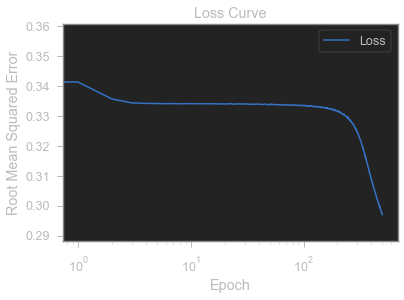

In [41]:
# Plot of the rmse metric vs epochs





plot_the_loss_curve(epochs, rmse)

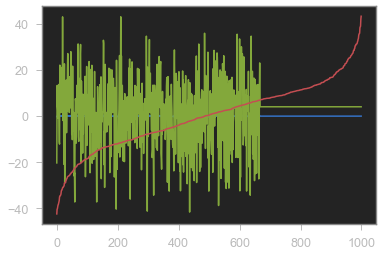

In [42]:
# plot_the_model
y0 = np.sort(predictions)
scaled_predictions = scaler.fit_transform(y0)
scaled_y0 = np.sort(scaled_predictions) 

plt.plot(y0)
plt.plot(scaled_y0)
plt.plot(np.sort(train_labels))

In [43]:
print(scaled_y0)


[[-2.02595463e+01]
 [ 1.32614985e+01]
 [ 4.77090645e+00]
 [ 2.83309984e+00]
 [-9.08809185e-01]
 [ 7.87849903e+00]
 [ 1.37231798e+01]
 [ 1.57694685e+00]
 [-1.11233158e+01]
 [-1.21116114e+01]
 [ 2.21059189e+01]
 [ 1.92737865e+01]
 [ 1.57694685e+00]
 [ 2.59336042e+00]
 [ 2.11180782e+01]
 [ 6.95029545e+00]
 [ 6.76474285e+00]
 [ 1.80036688e+00]
 [ 1.57694685e+00]
 [ 4.30106773e+01]
 [-1.87818813e+00]
 [ 3.02505589e+00]
 [ 2.10742130e+01]
 [-2.08061962e+01]
 [ 1.50218761e+00]
 [ 2.26551590e+01]
 [-2.84927979e+01]
 [-1.15934019e+01]
 [ 1.09168601e+00]
 [ 8.66069889e+00]
 [ 1.57694685e+00]
 [ 1.56632442e+01]
 [-7.17574596e+00]
 [ 2.85654140e+00]
 [ 2.12698984e+00]
 [ 2.03820934e+01]
 [ 2.71117477e+01]
 [ 2.41310062e+01]
 [ 9.16482735e+00]
 [ 2.94290638e+00]
 [ 1.34283133e+01]
 [ 1.57694685e+00]
 [ 1.70681133e+01]
 [ 1.47954712e+01]
 [ 6.05865431e+00]
 [ 3.61646771e+00]
 [ 2.79502335e+01]
 [ 7.61132479e+00]
 [ 1.05079260e+01]
 [-7.91349888e+00]
 [ 8.73320293e+00]
 [-1.01949263e+01]
 [ 2.1648468

In [44]:
print(y0)

[[-2.38169730e-01]
 [ 1.01944469e-01]
 [ 1.57964639e-02]
 [-3.86507856e-03]
 [-4.18315679e-02]
 [ 4.73270006e-02]
 [ 1.06628820e-01]
 [-1.66103691e-02]
 [-1.45470902e-01]
 [-1.55498430e-01]
 [ 1.91682503e-01]
 [ 1.62946880e-01]
 [-1.66103691e-02]
 [-6.29754411e-03]
 [ 1.81659594e-01]
 [ 3.79091799e-02]
 [ 3.60265076e-02]
 [-1.43434852e-02]
 [-1.66103691e-02]
 [ 4.03788239e-01]
 [-5.16671687e-02]
 [-1.91743707e-03]
 [ 1.81214526e-01]
 [-2.43716195e-01]
 [-1.73688978e-02]
 [ 1.97255254e-01]
 [-3.21706682e-01]
 [-1.50240526e-01]
 [-2.15339661e-02]
 [ 5.52634262e-02]
 [-1.66103691e-02]
 [ 1.26313269e-01]
 [-1.05417721e-01]
 [-3.62723367e-03]
 [-1.10294726e-02]
 [ 1.74192086e-01]
 [ 2.42473096e-01]
 [ 2.12229624e-01]
 [ 6.03784584e-02]
 [-2.75094854e-03]
 [ 1.03637017e-01]
 [-1.66103691e-02]
 [ 1.40567482e-01]
 [ 1.17508590e-01]
 [ 2.88623273e-02]
 [ 4.08319896e-03]
 [ 2.50980616e-01]
 [ 4.46161702e-02]
 [ 7.40059242e-02]
 [-1.12903170e-01]
 [ 5.59990704e-02]
 [-1.36051193e-01]
 [ 1.8704108

# Time consuming Errors Fixed

In [45]:
# Having problems with graph so going to skip building the matrix of for now and do 1 value at a time
# It was something to do with how I am storing the element data, maybe a transpose or something can fix it
# FIXED I had element1Data.append(data)  which created the data type [array([])] I removed the brackets, 
# another fix would be the .tolist() function. I spent way too long finding that error!

In [46]:
# print(element1Data.shape) something to do with array in an array problem

In [47]:
# I need to create the labels for the correlations
# this also has a distance term, but I set it up so that part of the eqn went to 1
# cos(theta) = phase/(2pi) # arccos only takes values on the unit circle!!!!!!!!!!!!!!!!!!!!!!
# I had a problem with radians and degrees earlier

In [48]:
# I think this is reformating my data scaled_train_samples[1], yes it is woooo! Need to normalize another way
# Fixed removed reshape. I thought the fit_transform was causing the issues, but the reshape was the one affecting
# the matrix shape. I thought it was scaling for some reason

In [49]:
# WARNING:tensorflow:Model was constructed with shape (None, 10, 100) for input Tensor("dense_input:0", shape=(None, 10, 100), dtype=float32), but it was called on an input with incompatible shape (5, 100).
# WARNING:tensorflow:Model was constructed with shape (None, 10, 100) for input Tensor("dense_input:0", shape=(None, 10, 100), dtype=float32), but it was called on an input with incompatible shape (5, 100).

In [50]:
# ValueError: Data cardinality is ambiguous: x sizes: 89, y sizes: 50, Please provide data which shares the same first dimension.
# I think this is a row, col issue. I planned on a 50xN sample matrix, but I think I have Nx50. Also my labels is a (#,). 
# I think I fixed the array issue, I was wrong about my previous guess. The problem was the correlation output being full and not same.
# Now I need to get my rows the samples to match the row of the labels
# another error was input size, expecting (10,100), but I was giving it the wrong thing. I don't know where (10,100) is coming from.
# FIIIIIIIIIIXXXXXXXXXXXEEEEEEEEEDDDDDDDDDDDDDDDDDDDDDD I was dumb and was trying to input a vector to to an element rather than having a input for each part 
# of the vector

In [51]:
# model.compile(
#   optimizer=Adam(learning_rate=0.0001),
#  loss='sparse_categorical_crossentropy', # this doesn't work because not using 1 hot encoding
#  metrics=['accuracy'])

In [52]:
# rounded_predictions = np.argmax(predictions, axis=1) not an either or choice so this doesn't work

In [53]:
# I think this will work for a 2d array I need to spend a couple min to confirm
# there is an extra empty set of bracks this is because it is a list in a list in a list, python really doesn't like 2d lists
# might switch to np.array, but then adding the data is harder
# might be easiest just entering the empty array in by hand

In [54]:
# print(corr)

# uggghhhh how do I get y and x to elements because i need 4 indexs
# want this behavior
# for y in range(num_elements-1):
#     for x in range(num_elements-y-1):   
#         test = m[y][x+y+1]
#         print(test)
# this out puts [10,20,21] whcich is the correct answer for a 3 elements array
# where 10 is element 1 corr with element 0, ect..
# need to convert those to y and x to elements the problem is 2 vars a 4 indexs

# Step search through to find best node/layer

In [55]:
# This section will step through all different combinations of layers and nodes
# current does 5 layers with all possible node combitions
# I know I could've did a functions to make this look better, but this is just
# brute force so I got it working and was happy with it :)

# Uncomment only if you are trying to find the new best architecture!!!!!!
# This will take FOREVER to run! The best cases should be up above already.

In [56]:
# # Test 1 Dense Layer solutions
# nodes = [16,32,64,128,256]
# bestRMSE = 50

# for i in range(len(nodes)):
#     model = tf.keras.models.Sequential()  # initilazing the model
#     model.add(tf.keras.Input(shape=(3, N)))  # input layer
#     model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
#     model.add(keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(1))
#     model.output_shape
# #     model.summary()
    
#     model.compile(
#     optimizer=Adam(learning_rate=0.000001),
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
#     history = model.fit(
#     x=scaled_train_samples,
#     y=scaled_train_labels,
#     validation_split=0.1,
#     batch_size=10,
#     epochs=50,
#     verbose=2)
    
#     hist = pd.DataFrame(history.history)
#     rmse = hist["root_mean_squared_error"]
#     temp = rmse[len(rmse)-1]
    
#     if temp < bestRMSE:
#         bestRMSE = temp
#         path = "models/DoARMS"
#         RMSE = str(temp)
#         fileType = ".h5"
#         model.save(path + RMSE + fileType)
        
# # Test 2 Dense Layer Solutions
# nodes = [16,32,64,128,256]

# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         model = tf.keras.models.Sequential()  # initilazing the model
#         model.add(tf.keras.Input(shape=(3, N)))  # input layer
#         model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
#         model.add(tf.keras.layers.Dense(nodes[j], activation='relu'))
#         model.add(keras.layers.Flatten())
#         model.add(tf.keras.layers.Dense(1))
#         model.output_shape
# #         model.summary()

#         model.compile(
#         optimizer=Adam(learning_rate=0.000001),
#         loss='mse',
#         metrics=[tf.keras.metrics.RootMeanSquaredError()])

#         history = model.fit(
#         x=scaled_train_samples,
#         y=scaled_train_labels,
#         validation_split=0.1,
#         batch_size=10,
#         epochs=50,
#         verbose=2)

#         hist = pd.DataFrame(history.history)
#         rmse = hist["root_mean_squared_error"]
#         temp = rmse[len(rmse)-1]

#         if temp < bestRMSE:
#             bestRMSE = temp
#             path = "models/DoARMS"
#             RMSE = str(temp)
#             fileType = ".h5"
#             model.save(path + RMSE + fileType)
        
# # Test 3 Dense Layer Solutions
# nodes = [16,32,64,128,256]

# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         for k in range(len(nodes)):
#             model = tf.keras.models.Sequential()  # initilazing the model
#             model.add(tf.keras.Input(shape=(3, N)))  # input layer
#             model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
#             model.add(tf.keras.layers.Dense(nodes[j], activation='relu'))
#             model.add(tf.keras.layers.Dense(nodes[k], activation='relu'))
#             model.add(keras.layers.Flatten())
#             model.add(tf.keras.layers.Dense(1))
#             model.output_shape
# #             model.summary()

#             model.compile(
#             optimizer=Adam(learning_rate=0.000001),
#             loss='mse',
#             metrics=[tf.keras.metrics.RootMeanSquaredError()])

#             history = model.fit(
#             x=scaled_train_samples,
#             y=scaled_train_labels,
#             validation_split=0.1,
#             batch_size=10,
#             epochs=50,
#             verbose=2)

#             hist = pd.DataFrame(history.history)
#             rmse = hist["root_mean_squared_error"]
#             temp = rmse[len(rmse)-1]

#             if temp < bestRMSE:
#                 bestRMSE = temp
#                 path = "models/DoARMS"
#                 RMSE = str(temp)
#                 fileType = ".h5"
#                 model.save(path + RMSE + fileType)
            
# # Test 4 Dense Layer Solutions
# nodes = [16,32,64,128,256]

# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         for k in range(len(nodes)):
#             for h in range(len(nodes)):
#                 model = tf.keras.models.Sequential()  # initilazing the model
#                 model.add(tf.keras.Input(shape=(3, N)))  # input layer
#                 model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
#                 model.add(tf.keras.layers.Dense(nodes[j], activation='relu'))
#                 model.add(tf.keras.layers.Dense(nodes[k], activation='relu'))
#                 model.add(tf.keras.layers.Dense(nodes[h], activation='relu'))
#                 model.add(keras.layers.Flatten())
#                 model.add(tf.keras.layers.Dense(1))
#                 model.output_shape
# #                 model.summary()

#                 model.compile(
#                 optimizer=Adam(learning_rate=0.000001),
#                 loss='mse',
#                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

#                 history = model.fit(
#                 x=scaled_train_samples,
#                 y=scaled_train_labels,
#                 validation_split=0.1,
#                 batch_size=10,
#                 epochs=50,
#                 verbose=2)

#                 hist = pd.DataFrame(history.history)
#                 rmse = hist["root_mean_squared_error"]
#                 temp = rmse[len(rmse)-1]

#                 if temp < bestRMSE:
#                     bestRMSE = temp
#                     path = "models/DoARMS"
#                     RMSE = str(temp)
#                     fileType = ".h5"
#                     model.save(path + RMSE + fileType)
                
# # Test 5 Dense Layer Solutions
# nodes = [16,32,64,128,256]

# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         for k in range(len(nodes)):
#             for h in range(len(nodes)):
#                 for g in range(len(nodes)):
#                     model = tf.keras.models.Sequential()  # initilazing the model
#                     model.add(tf.keras.Input(shape=(3, N)))  # input layer
#                     model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
#                     model.add(tf.keras.layers.Dense(nodes[j], activation='relu'))
#                     model.add(tf.keras.layers.Dense(nodes[k], activation='relu'))
#                     model.add(tf.keras.layers.Dense(nodes[h], activation='relu'))
#                     model.add(tf.keras.layers.Dense(nodes[g], activation='relu'))
#                     model.add(keras.layers.Flatten())
#                     model.add(tf.keras.layers.Dense(1))
#                     model.output_shape
#     #                 model.summary()

#                     model.compile(
#                     optimizer=Adam(learning_rate=0.000001),
#                     loss='mse',
#                     metrics=[tf.keras.metrics.RootMeanSquaredError()])

#                     history = model.fit(
#                     x=scaled_train_samples,
#                     y=scaled_train_labels,
#                     validation_split=0.1,
#                     batch_size=10,
#                     epochs=50,
#                     verbose=2)

#                     hist = pd.DataFrame(history.history)
#                     rmse = hist["root_mean_squared_error"]
#                     temp = rmse[len(rmse)-1]

#                     if temp < bestRMSE:
#                         bestRMSE = temp
#                         path = "models/DoARMS"
#                         RMSE = str(temp)
#                         fileType = ".h5"
#                         model.save(path + RMSE + fileType)

In [57]:
# This was my starting state for training
# model = tf.keras.models.Sequential()
# model.add(tf.keras.Input(shape=(3,N)))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(1))
# model.output_shape

# model.summary()

In [58]:
# Notes
# shrinking layer 1 to 64 decreases preformance
# layer 4 removal? does seem to do much
# Removing layer 3&4 improved a lot 
# removing layer 2-4 didn't change much from remover 3&4
# shrinking layer 1 without more layers sucks
# growing layer 1 without more layers sucks
# 2 layers : 128,16 worse 2.2587
# 2 layers : 128,32 best 0.8847
# 2 layers : 128,64 worse 3.9242
# 2 layers : 128,128 worse 2.7022
# 3 layers : 128,32,32 best 0.3309

In [59]:
# # Checks first to see if file exists already. If not, the model is saved to disk
# import os.path
# if os.path.isfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\DoARMS100.h5") is False:
# #     model.save("models/Test.h5")
    
#     path = "models/DoARMS"
#     RMSE = "100"
#     fileType = ".h5"
#     model.save(path + RMSE + fileType)

# # This save functions saves:
# # architecture of the model
# # weights of the model
# # traing config
# # State of the optimizer

In [60]:
# from tensorflow.keras.models import load_model
# new_model = load_model('models/medical_trial_model.h5')

# Water Mark

In [61]:
%load_ext watermark

%watermark -v -m -p math

CPython 3.8.3
IPython 7.18.1

math unknown

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores  : 8
interpreter: 64bit
